In [1]:
import itertools

import numpy as np
import scipy as sp

import pandas as pd

# PGF plotting
import matplotlib
matplotlib.use("pgf")
%matplotlib inline
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'sans',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

import matplotlib.pyplot as plt
pd.plotting.register_matplotlib_converters()
pd.options.mode.chained_assignment = None # suppress chained assignment warning

# Machine learning
from sklearn.model_selection import train_test_split as skl_ttsplit
import sklearn.decomposition as skl_dcmp
from sklearn.metrics import adjusted_rand_score

from pyclustering.cluster.kmedoids import kmedoids as KMedoids


import re

# Multiprocessing
from multiprocessing import Pool

In [2]:
cluster_file_wildcard = 'clusters/yearly_clusters_{}.csv'

avg_correlations_file = 'sp500/sp500_yearly_avg.csv'
avg_correlations_detrended_file = 'sp500/sp500_yearly_avg_detrended.csv'

vola_filename = 'sp500/sp500_yearly_vola.csv'

statement_data_file = '../data/financial_data/data2000_2020_edited.csv'
statement_benchmarks = ['ebit_margin', 'leverage', 'ebit', 'div_ebit']
intra_cluster_std_filename = 'clusters/intra_cluster_stds_{}.csv'

ARI_file_wildcard = 'clusters/yearly_ARIs_{}.csv'

In [3]:
# Loading data
# company data
company_data = pd.read_csv('company_data.csv')
company_data_convert_dict = {'ggroup': 'Int32', 'gind': 'Int32', 'gsector': 'Int32', 'gsubind': 'Int32', 'naics': 'Int32', 'sic': 'Int32', 'spcindcd': 'Int32', 'spcseccd': 'Int32'}
company_data = company_data.astype(company_data_convert_dict)

# average correlations
avg_correlations = pd.read_csv(avg_correlations_file, index_col = 'year')
avg_detrended_correlations = pd.read_csv(avg_correlations_detrended_file, index_col = 'year')

# volatility
yearly_vola = pd.read_csv(vola_filename, index_col = 'year')

# clusters
years = np.arange(2000, 2021)
yearly_clusters = {}
for year in years:
    yearly_clusters[year] = pd.read_csv(cluster_file_wildcard.format(year), index_col = 0)
    yearly_clusters[year].mask(yearly_clusters[year] == -1, inplace=True) # set -1 values Nan

sp500_columns = [col for col in yearly_clusters[2000].columns if col[0:3] == 'sp_']
sp500_n_clusters = [int(col[3:]) for col in sp500_columns]
statement_columns = [col for col in yearly_clusters[2000].columns if col[0:3] == 'st_']
statement_n_clusters = [int(col[3:]) for col in statement_columns]

sp500_ismedoid_columns = ['ismedoid_{}'.format(col) for col in sp500_columns]
statement_ismedoid_columns = ['ismedoid_{}'.format(col) for col in statement_columns]
# medoids
yearly_medoids = {}
for year in years:
    yearly_medoids[year] = {}
    for col in sp500_ismedoid_columns + statement_ismedoid_columns:
        yearly_medoids[year][col] = list(yearly_clusters[year][yearly_clusters[year][col] == 1].index)

# statement data
statement_data = pd.read_csv(statement_data_file)

In [4]:
"""
Transform cluster labels for ticker symbols into lists of ticker symbols.

cluster_labels: data series
"""
def make_cluster_lists(cluster_labels, include_nan = False):
    unique_labels = cluster_labels.unique()
    unique_labels.sort()
    clusters = {}
    
    for label in unique_labels:
        if not(label is None or np.isnan(label) or label < 0) or include_nan:
            clusters[label] = cluster_labels[cluster_labels == label].index.to_list() if not np.isnan(label) else cluster_labels[cluster_labels.isnull()].index.to_list()
    return clusters

## Average SP500 Correlations

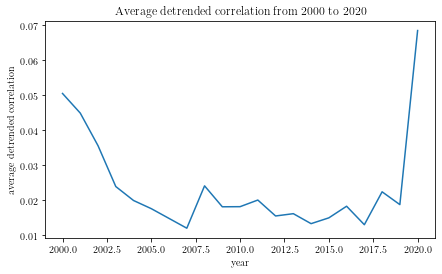

In [5]:
"""
plt.figure(figsize=(7,4))
plt.plot(avg_correlations.index, avg_correlations['avg_corr'])
plt.title('Average correlation from 2000 to 2020')
plt.ylabel('average correlation')
plt.xlabel('year')
plt.show()
"""
plt.figure(figsize=(7,4))
plt.plot(avg_detrended_correlations.index, avg_detrended_correlations['avg_corr'])
plt.title('Average detrended correlation from 2000 to 2020')
plt.ylabel('average detrended correlation')
plt.xlabel('year')
plt.show()

## Disparity Analysis

In [6]:
def calculate_coefficient_of_variation(clusters):
    if type(clusters) == dict:
        clusters = clusters.values()
    N_cl = len(clusters)
    cluster_sizes = [len(x) for x in clusters]
    avg_cluster_size = np.mean(cluster_sizes)
    
    if avg_cluster_size > 0 and N_cl > 1:
        sigma_S = np.sqrt(1/(N_cl-1) * np.sum((cluster_sizes-avg_cluster_size)**2))
        return sigma_S / avg_cluster_size

In [7]:
# Let's look at yearly disparity of sp500 clusters
sp500_yearly_disparities = pd.DataFrame(index = years, columns = sp500_n_clusters)
statement_yearly_disparities = pd.DataFrame(index = years, columns = statement_n_clusters)
reference_yearly_disparities = pd.DataFrame(index = years, columns = ['sic_1', 'sic_2', 'naics_2', 'naics_3', 'naics_4', 'gsector', 'ggroup', 'spcseccd', 'spcindcd', 'hp'])
for year in years:
    sp500_yearly_disparities.at[year] = [calculate_coefficient_of_variation(make_cluster_lists(yearly_clusters[year]['sp_{}'.format(n)])) for n in sp500_n_clusters]
    statement_yearly_disparities.at[year] = [calculate_coefficient_of_variation(make_cluster_lists(yearly_clusters[year]['st_{}'.format(n)])) for n in statement_n_clusters]
    
    for column in reference_yearly_disparities.columns:
        reference_yearly_disparities.at[year, column] = calculate_coefficient_of_variation(make_cluster_lists(yearly_clusters[year][column]))

/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:3256: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/lib/python3/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [8]:
# average, min, max disparity
sp500_avg_disparities = sp500_yearly_disparities.mean(axis=0)
sp500_min_disparities = sp500_yearly_disparities.min(axis=0)
sp500_max_disparities = sp500_yearly_disparities.max(axis=0)

statement_avg_disparities = statement_yearly_disparities.mean(axis=0)
statement_min_disparities = statement_yearly_disparities.mean(axis=0)
statement_max_disparities = statement_yearly_disparities.mean(axis=0)

reference_avg_disparities = reference_yearly_disparities.mean(axis=0)

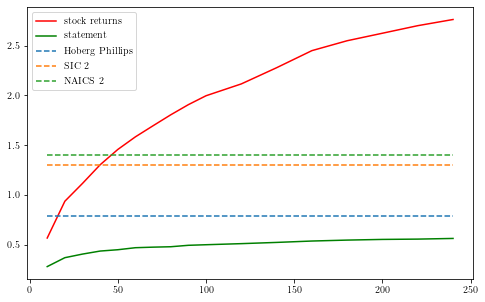

In [9]:
plt.figure(figsize=(8,5))
plt.plot(sp500_avg_disparities, label = 'stock returns', color = 'red')
plt.plot(statement_avg_disparities, label = 'statement', color = 'green')
#plt.plot(sp500_min_disparities, label = 'min')
#plt.plot(sp500_max_disparities, label = 'max')
plt.plot(sp500_avg_disparities.index, len(sp500_avg_disparities.index) * [reference_avg_disparities['hp']], label = 'Hoberg Phillips', linestyle='dashed')
#plt.plot(sp500_avg_disparities.index, len(sp500_avg_disparities.index) * [reference_avg_disparities['sic_1']], label = 'SIC 1', linestyle='dashed')
plt.plot(sp500_avg_disparities.index, len(sp500_avg_disparities.index) * [reference_avg_disparities['sic_2']], label = 'SIC 2', linestyle='dashed')
plt.plot(sp500_avg_disparities.index, len(sp500_avg_disparities.index) * [reference_avg_disparities['naics_2']], label = 'NAICS 2', linestyle='dashed')
#plt.title('Year-aggregated Disparities for S\&P 500 Clusters')
plt.legend()
plt.show()

## Adjusted Rand Index

In [10]:
"""
Calculate Adjusted Rand Index between two clusterings

reference_labels, probe_labels: each a data series of cluster labels
"""
def calculate_ARI(reference_labels, probe_labels):
    reference_nan_indices = reference_labels.isnull()
    probe_nan_indices = probe_labels.isnull()
    nan_indices = reference_nan_indices | probe_nan_indices
    return adjusted_rand_score(reference_labels[~nan_indices].to_numpy(), probe_labels[~nan_indices].to_numpy())

In [11]:
# Calculate adjusted rand indices
yearly_ARIs = {}
print('Calculating ARI for ', end='')
for year in years:
    print('{} '.format(year), end='')
    all_clusterings = [col for col in yearly_clusters[year].columns if not col.startswith('ismedoid')]
    
    yearly_ARIs[year] = pd.DataFrame(index = all_clusterings, columns = all_clusterings)
    for x in all_clusterings:
        for y in all_clusterings:
            yearly_ARIs[year].at[y, x] = calculate_ARI(yearly_clusters[year][x], yearly_clusters[year][y])

Calculating ARI for 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 

In [12]:
for year in yearly_ARIs:
    yearly_ARIs[year].to_csv(ARI_file_wildcard.format(year))    

In [13]:
# Calculate average ARIs
average_ARIs = pd.DataFrame(0, index = all_clusterings, columns = all_clusterings)
for year in yearly_ARIs:
    average_ARIs += yearly_ARIs[year]
average_ARIs /= len(yearly_ARIs)

average_ARIs_no2020 = pd.DataFrame(0, index = all_clusterings, columns = all_clusterings)
for year in yearly_ARIs:
    if year != 2020:
        average_ARIs_no2020 += yearly_ARIs[year]
average_ARIs_no2020 /= len(yearly_ARIs) - 1


In [14]:
"""
Plot the ARI versus a certain comparison clustering.

compare_to: name of clustering to compare to
plot: sp, st or both
"""
def plot_ARI_vs_n(ARI_matrix, compare_to = 'sic_2', plot = ['sp', 'st']):
    sp_series = ARI_matrix[compare_to].loc[sp500_columns]
    st_series = ARI_matrix[compare_to].loc[statement_columns]
    
    plt.figure(figsize=(8,5))
    plt.title('Adjusted RAND Index for different $n_{{clusters}}$ comparing to {}'.format(compare_to))
    plt.ylabel('Adjusted RAND Index')
    plt.xlabel('$n_{clusters}$')
    
    if plot == 'sp' or 'sp' in plot or 'sp500' in plot:
        plt.plot(sp500_n_clusters, sp_series, label = 'S&P 500')
    if plot == 'st' or plot == 'statement' or 'st' in plot or 'statement' in plot:
        plt.plot(statement_n_clusters, st_series, label = 'statement data')
    plt.legend()
    plt.show()
    
"""
Plot the ARI for a certain comparator and for certain ns over the years.
"""
def plot_ARI_vs_year(yearly_ARIs, n_clusters, compare_to = 'sic_2', plot = ['sp', 'st']):
    plt.figure(figsize=(8,5))
    plt.title('Adjusted RAND Index time evolution comparing to {}'.format(compare_to))
    plt.ylabel('Adjusted RAND Index')
    plt.xlabel('$year$')
    for n in n_clusters:
        sp_series = [yearly_ARIs[year][compare_to]['sp_{}'.format(n)] for year in yearly_ARIs]
        st_series = [yearly_ARIs[year][compare_to]['st_{}'.format(n)] for year in yearly_ARIs]
        
        if plot == 'sp' or 'sp' in plot or 'sp500' in plot:
            plt.plot(years, sp_series, label = 'S&P 500, n = {}'.format(n))
        if plot == 'st' or plot == 'statement' or 'st' in plot or 'statement' in plot:
            plt.plot(years, st_series, label = 'statement data, n = {}'.format(n))
    plt.legend()
    plt.locator_params(axis="x", integer=True)
    plt.show()

In [15]:
# Attention: Switch off LaTeX for making these functions work
#plot_ARI_vs_n(average_ARIs, compare_to = 'naics_3', plot = 'spst')
#plot_ARI_vs_n(average_ARIs, compare_to = 'sic_1', plot = 'spst')

In [16]:
#plot_ARI_vs_year(yearly_ARIs, n_clusters=[10, 30, 90], compare_to = 'gsector', plot='spst')

In [17]:
#plot_ARI_vs_year(yearly_ARIs, n_clusters=[10, 30, 90], compare_to = 'naics_4', plot='spst')

## Intra and Inter Cluster Statement Variance

In [18]:
"""
Calculate the inter and intra cluster standard deviations of a statement data variable.

cluster_lists: list of ticker symbol lists

returns: weighted average intra-cluster standard deviation, standard deviation of all available companies
"""
def calculate_intra_cluster_stds(cluster_lists, statement_data, outlier_barrier = None):
    available_benchmarks = []
    intra_benchmark_stds = []
    cluster_sizes = []
    
    for cluster_idx in cluster_lists:
        available_tics = statement_data.index.intersection(cluster_lists[cluster_idx])
        cluster_statement_data = statement_data.loc[available_tics] # find tics for which statement data is available
        cluster_statement_data = cluster_statement_data[~cluster_statement_data.isin([np.inf, -np.inf, np.nan])]
        
        # remove unrealistic outliers
        if outlier_barrier is not None:
            cluster_statement_data = cluster_statement_data[cluster_statement_data < outlier_barrier]
            cluster_statement_data = cluster_statement_data[cluster_statement_data > - outlier_barrier]        
        
        available_benchmarks += cluster_statement_data.to_list()
        intra_benchmark_stds.append(cluster_statement_data.std() if not np.isnan(cluster_statement_data.std()) else 0)
        cluster_sizes.append(len(cluster_statement_data))
        
    # return the cluster-size-weighted average of intra-cluster stds and the overall std
    return (
        np.average(intra_benchmark_stds, weights = cluster_sizes) if len(cluster_sizes) > 0 else np.nan, # intra-cluster std
        np.std(available_benchmarks) if len(intra_benchmark_stds) > 1 else np.nan # overall std
    )

In [19]:
# Example for 2019
statement_data_2019 = statement_data[statement_data['fyear'] == 2019].set_index('tic')
calculate_intra_cluster_stds(make_cluster_lists(yearly_clusters[2019]['sic_1']), statement_data_2019['ebit_margin'], 10)

(0.17243657218135908, 0.21690100325853864)

In [20]:
# Let's calculate intra-cluster / overall stds for all benchmarking variables for all years for all clustering methods.

intra_cluster_stds = {}
intra_cluster_std_ratios = {}

"""
Calculate the intra cluster and overall stds for a certain year.

returns: list of tuples (intra-cluster, overall std), list of ratios (intra-cluster std / overall std)
"""
def calculate_stds(year):
    print('{} '.format(year), end = '')
    tuples = []
    ratios = []
    for clustering_method in intra_cluster_stds[statement_benchmark].columns:
        yearly_statement_data = statement_data[statement_data['fyear'] == year].set_index('tic')
        intra, inter = calculate_intra_cluster_stds(
            make_cluster_lists(yearly_clusters[year][clustering_method]), 
            yearly_statement_data[statement_benchmark],
            outlier_barrier=10 if statement_benchmark == 'ebit_margin' else None # filter out ebit_margin outliers
        )
        tuples.append((intra, inter))
        ratios.append((intra / inter))
    return tuples, ratios
        

for statement_benchmark in statement_benchmarks:
    print('Calculating for {} ( '.format(statement_benchmark), end='')
    intra_cluster_stds[statement_benchmark] = pd.DataFrame(columns = [col for col in yearly_clusters[2000].columns if not col.startswith('ismedoid')], index = years)
    intra_cluster_std_ratios[statement_benchmark] = pd.DataFrame(columns = [col for col in yearly_clusters[2000].columns if not col.startswith('ismedoid')], index = years)
    with Pool(6) as pool:
        res = pool.map(calculate_stds, years)
        print('multiproc done ', end='')
    for i, year in enumerate(years):
        intra_cluster_stds[statement_benchmark].loc[year] = res[i][0]
        intra_cluster_std_ratios[statement_benchmark].loc[year] = res[i][1]
    print(')')

Calculating for ebit_margin ( multiproc done )
Calculating for leverage ( multiproc done )
Calculating for ebit ( multiproc done )
Calculating for div_ebit ( multiproc done )


In [21]:
for statement_benchmark in intra_cluster_stds:
    intra_cluster_stds[statement_benchmark].to_csv(intra_cluster_std_filename.format(statement_benchmark))

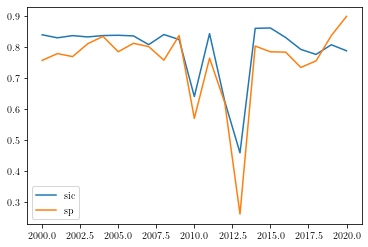

In [23]:
plt.plot(intra_cluster_std_ratios['leverage']['naics_2'], label='sic')
plt.plot(intra_cluster_std_ratios['leverage']['sp_30'], label='sp')
plt.legend()

## Regressions

In [24]:
yearly_sp30_vs_naics_2_ARIs = np.array([yearly_ARIs[year].at['sp_30', 'naics_2'] for year in yearly_ARIs])
yearly_sp30_vs_naics_3_ARIs = np.array([yearly_ARIs[year].at['sp_30', 'naics_3'] for year in yearly_ARIs])
yearly_sp30_vs_hp_ARIs = np.array([yearly_ARIs[year].at['sp_30', 'hp'] for year in yearly_ARIs])
yearly_sp120_vs_naics_4_ARIs = np.array([yearly_ARIs[year].at['sp_120', 'naics_4'] for year in yearly_ARIs])
yearly_st10_vs_sic_1_ARIs = np.array([yearly_ARIs[year].at['st_10', 'sic_1'] for year in yearly_ARIs])
yearly_st30_vs_hp_ARIs = np.array([yearly_ARIs[year].at['st_30', 'hp'] for year in yearly_ARIs])
yearly_st100_vs_sic_2_ARIs = np.array([yearly_ARIs[year].at['st_100', 'sic_2'] for year in yearly_ARIs])

In [25]:
# ARI vs correlation
def plot_ARI_regression(y_data, use_vola = False):
    x = avg_detrended_correlations['avg_corr'] if not use_vola else yearly_vola['vola']
    x_space = np.linspace(0.0, 0.03 if use_vola else 0.08)
    slope, intercept, r_value, p_value, _ = sp.stats.linregress(x=x, y=y_data)
    plt.scatter(x, y_data)
    plt.plot(x_space, intercept + slope * x_space)
    plt.show()
    print('R²:', r_value**2, 'p:', p_value)

==== CORR ====
---- stock returns ----


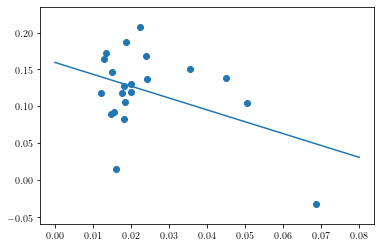

R²: 0.18011893222921438 p: 0.05516785815045212


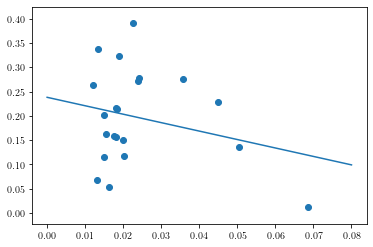

R²: 0.06511355510595594 p: 0.26426960851782316


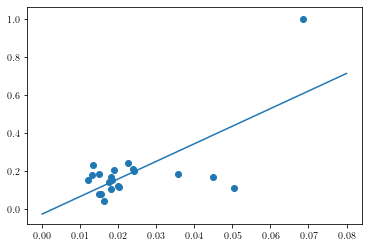

R²: 0.4800283170976757 p: 0.0004986363700323253
---- statement ----


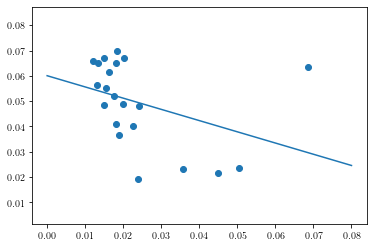

R²: 0.14550843576616143 p: 0.08796699878716223


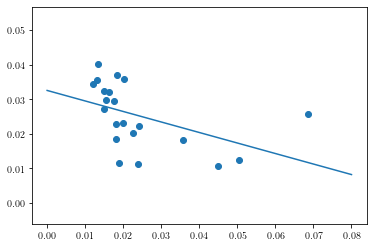

R²: 0.22413231225584704 p: 0.030176766773909493


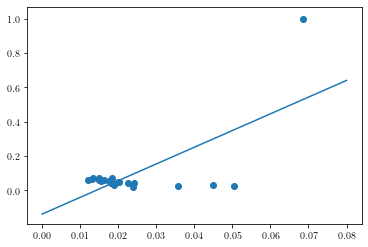

R²: 0.4522689658383789 p: 0.0008378158789755653
==== VOLA ====
---- stock returns ----


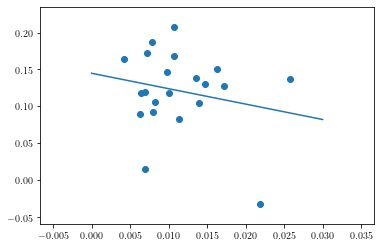

R²: 0.043602141725704875 p: 0.363682450155267


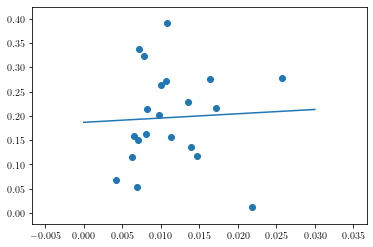

R²: 0.002410462016738525 p: 0.8326232532612778


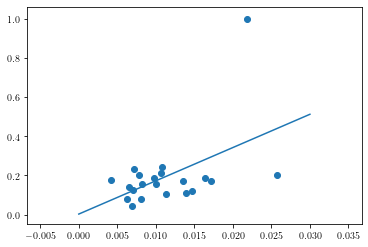

R²: 0.23378540559284122 p: 0.026376551849992706
---- statement ----


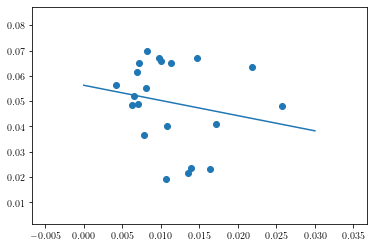

R²: 0.038222349587183665 p: 0.3957152418871882


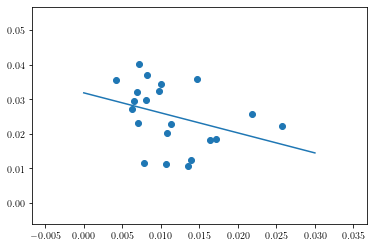

R²: 0.11663595549052377 p: 0.1297237620194253


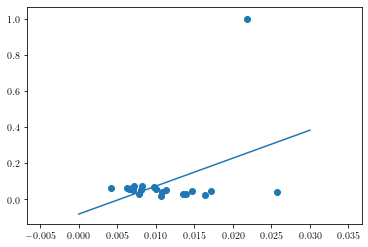

R²: 0.1643042940783743 p: 0.06831171297651907


In [26]:
print('==== CORR ====')
print('---- stock returns ----')
plot_ARI_regression(yearly_sp30_vs_naics_2_ARIs)
plot_ARI_regression(yearly_sp120_vs_naics_4_ARIs)
plot_ARI_regression(yearly_sp30_vs_hp_ARIs)
print('---- statement ----')
plot_ARI_regression(yearly_st10_vs_sic_1_ARIs)
plot_ARI_regression(yearly_st100_vs_sic_2_ARIs)
plot_ARI_regression(yearly_st30_vs_hp_ARIs)

print('==== VOLA ====')
print('---- stock returns ----')
plot_ARI_regression(yearly_sp30_vs_naics_2_ARIs, True)
plot_ARI_regression(yearly_sp120_vs_naics_4_ARIs, True)
plot_ARI_regression(yearly_sp30_vs_hp_ARIs, True)
print('---- statement ----')
plot_ARI_regression(yearly_st10_vs_sic_1_ARIs, True)
plot_ARI_regression(yearly_st100_vs_sic_2_ARIs, True)
plot_ARI_regression(yearly_st30_vs_hp_ARIs, True)

# === RELEVANT GRAPHS ===

1. Disparity (histogram, yearly)
2. ARI (avg ARI vs n clusters, 1x stock 1x statement yearly)
3. Correlations (Regressions) (NOT GOOD)
4. Intra-Cluster Variances

In [27]:
"""
Save plot in different formats
"""
def saveplot(figure, identifier):
    endings = ['pdf', 'pgf']
    figure.tight_layout()
    for ending in endings:
        figure.savefig('plots/{identifier}.{ending}'.format(identifier=identifier, ending=ending))

**Disparity**

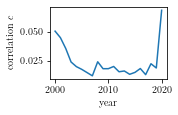

In [204]:
plt.figure(figsize=(2.5, 1.7))
plt.plot(avg_detrended_correlations.index, avg_detrended_correlations['avg_corr'])
#plt.title('Average Detrended S\&P 500 Correlation from 2000 to 2020')
plt.ylabel('correlation $c$')
plt.xlabel('year')
plt.locator_params(axis="x", integer=True)
saveplot(plt.gcf(), 'avg_correlation')
plt.show()

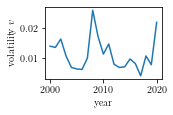

In [205]:
plt.figure(figsize=(2.5, 1.7))
plt.plot(yearly_vola.index, yearly_vola['vola'])
plt.ylabel('volatility $v$')
plt.xlabel('year')
plt.locator_params(axis="x", integer=True)
saveplot(plt.gcf(), 'volatility')
plt.show()

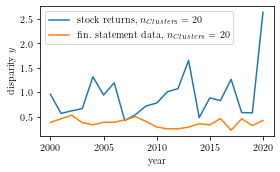

In [206]:
plt.figure(figsize=(4, 2.5))
plt.plot(sp500_yearly_disparities[20], label = 'stock returns, $n_{Clusters}$ = 20')
#plt.plot(sp500_yearly_disparities[100], label = 'stock returns, n = 100')
plt.plot(statement_yearly_disparities[20], label = 'fin. statement data, $n_{Clusters}$ = 20')
#plt.plot(statement_yearly_disparities[100], label = 'fin. statement data, n = 100')
#plt.title('Average Detrended S\&P 500 Correlation from 2000 to 2020')
plt.ylabel('disparity $y$')
plt.xlabel('year')
plt.locator_params(axis="x", integer=True)
plt.legend()
saveplot(plt.gcf(), 'yearly_disparity')
plt.show() 

In [207]:
"""
plt.figure(figsize=(6, 2.5))
plt.plot(sp500_avg_disparities, label = 'stock returns')
plt.plot(statement_avg_disparities, label = 'fin. statement data')
#plt.title('Average Detrended S\&P 500 Correlation from 2000 to 2020')
plt.ylabel('year-averaged disparity $y$')
plt.xlabel('number $n_{clusters}$ of clusters')
plt.locator_params(axis="x", integer=True)
plt.legend()
saveplot(plt.gcf(), 'disparity_vs_n')
plt.show() 
"""

'\nplt.figure(figsize=(6, 2.5))\nplt.plot(sp500_avg_disparities, label = \'stock returns\')\nplt.plot(statement_avg_disparities, label = \'fin. statement data\')\n#plt.title(\'Average Detrended S\\&P 500 Correlation from 2000 to 2020\')\nplt.ylabel(\'year-averaged disparity $y$\')\nplt.xlabel(\'number $n_{clusters}$ of clusters\')\nplt.locator_params(axis="x", integer=True)\nplt.legend()\nsaveplot(plt.gcf(), \'disparity_vs_n\')\nplt.show() \n'

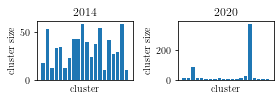

In [208]:
fig, axes = plt.subplots(1, 2, figsize=(4,1.5), squeeze  = False)
#plt.suptitle('Cluster Size Histogram for 10 k-Medoid clusters')
for year, ax in zip([2014,2020], axes.ravel()):
    ax.set_title(year)
    ax.set_xlabel('cluster')
    ax.set_ylabel('cluster size')
    ax.tick_params(labelbottom=False, bottom=False)
    cluster_lists = make_cluster_lists(yearly_clusters[year]['sp_20'])
    ax.bar(np.arange(1,21), [len(x) for x in cluster_lists.values()], label=year)
saveplot(plt.gcf(), 'disparity_histograms_sp500_selected')
plt.show()

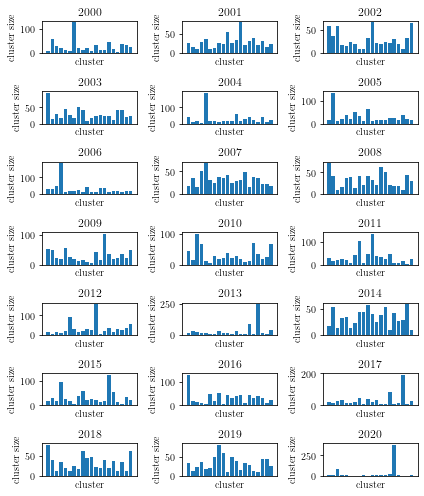

In [209]:
fig, axes = plt.subplots(7, 3, figsize=(6,7), squeeze  = False)
#plt.suptitle('Cluster Size Histogram for 10 k-Medoid clusters')
for year, ax in zip([x for x in range(2000, 2021)], axes.ravel()):
    ax.set_title(year)
    ax.set_xlabel('cluster')
    ax.set_ylabel('cluster size')
    ax.tick_params(labelbottom=False, bottom=False)
    cluster_lists = make_cluster_lists(yearly_clusters[year]['sp_20'])
    ax.bar(np.arange(1,21), [len(x) for x in cluster_lists.values()], label=year)
saveplot(plt.gcf(), 'disparity_histograms_sp500_all')
plt.show()

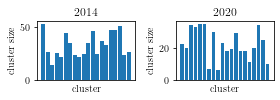

In [210]:
fig, axes = plt.subplots(1, 2, figsize=(4,1.5), squeeze  = False)
#plt.suptitle('Cluster Size Histogram for 10 k-Medoid clusters')
for year, ax in zip([2014, 2020], axes.ravel()):
    ax.set_title(year)
    ax.set_xlabel('cluster')
    ax.set_ylabel('cluster size')
    ax.tick_params(labelbottom=False, bottom=False)
    cluster_lists = make_cluster_lists(yearly_clusters[year]['st_20'])
    ax.bar(np.arange(1,21), [len(x) for x in cluster_lists.values()], label=year)
saveplot(plt.gcf(), 'disparity_histograms_statement_selected')
plt.show()

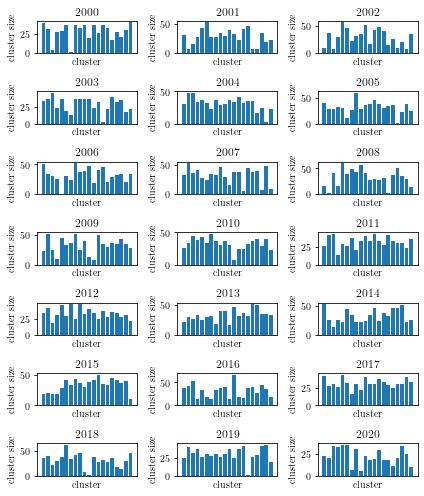

In [211]:
fig, axes = plt.subplots(7, 3, figsize=(6,7), squeeze  = False)
#plt.suptitle('Cluster Size Histogram for 10 k-Medoid clusters')
for year, ax in zip([x for x in range(2000,2021)], axes.ravel()):
    ax.set_title(year)
    ax.set_xlabel('cluster')
    ax.set_ylabel('cluster size')
    ax.tick_params(labelbottom=False, bottom=False)
    cluster_lists = make_cluster_lists(yearly_clusters[year]['st_20'])
    ax.bar(np.arange(1,21), [len(x) for x in cluster_lists.values()], label=year)
#axes.ravel()[-1].set_visible(False)
saveplot(plt.gcf(), 'disparity_histograms_statement_all')
plt.show()

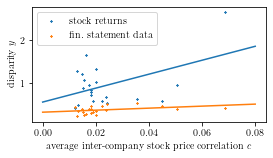

stock ret: R²: 0.2158113969035024 p: 0.0338641027345372 slope: 16.234258007888133
statement: R²: 0.15727059891464681 p: 0.07509917995703351 slope: 2.3462117436374057


In [212]:
# Regression: disparity vs correlation
plt.figure(figsize=(4, 2.3))
x = avg_detrended_correlations['avg_corr']
x_space = np.linspace(0.0, 0.08)
y_sp = sp500_yearly_disparities[20].astype('float')
y_st = statement_yearly_disparities[20].astype('float')
slope_sp, intercept_sp, r_value_sp, p_value_sp, _ = sp.stats.linregress(x=x, y=y_sp)
slope_st, intercept_st, r_value_st, p_value_st, _ = sp.stats.linregress(x=x, y=y_st)
plt.scatter(x, y_sp, label = 'stock returns', s = 2, marker = 'x')
plt.scatter(x, y_st, label = 'fin. statement data', s = 2, marker = 'x')
plt.plot(x_space, intercept_sp + slope_sp * x_space)
plt.plot(x_space, intercept_st + slope_st * x_space)
plt.xlabel('average inter-company stock price correlation $c$')
plt.ylabel('disparity $y$')
plt.legend()
saveplot(plt.gcf(), 'disparity_vs_correlation')
plt.show()
print('stock ret: R²:', r_value_sp**2, 'p:', p_value_sp, 'slope:', slope_sp)
print('statement: R²:', r_value_st**2, 'p:', p_value_st, 'slope:', slope_st)

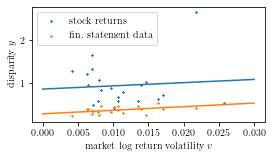

stock ret: R²: 0.006545938626600156 p: 0.7273658327100416 slope: 7.463841782375045
statement: R²: 0.28606614807160874 p: 0.012483721241433893 slope: 8.353296024778086


In [213]:
# Regression: disparity vs volatility
plt.figure(figsize=(4, 2.3))
x = yearly_vola['vola']
x_space = np.linspace(0.00, 0.03)
y_sp = sp500_yearly_disparities[20].astype('float')
y_st = statement_yearly_disparities[20].astype('float')
slope_sp, intercept_sp, r_value_sp, p_value_sp, _ = sp.stats.linregress(x=x, y=y_sp)
slope_st, intercept_st, r_value_st, p_value_st, _ = sp.stats.linregress(x=x, y=y_st)
plt.scatter(x, y_sp, label = 'stock returns', s = 2, marker = 'x')
plt.scatter(x, y_st, label = 'fin. statement data', s = 2, marker = 'x')
plt.plot(x_space, intercept_sp + slope_sp * x_space)
plt.plot(x_space, intercept_st + slope_st * x_space)
plt.xlabel('market log return volatility $v$')
plt.ylabel('disparity $y$')
plt.legend()
saveplot(plt.gcf(), 'disparity_vs_volatility')
plt.show()
print('stock ret: R²:', r_value_sp**2, 'p:', p_value_sp, 'slope:', slope_sp)
print('statement: R²:', r_value_st**2, 'p:', p_value_st, 'slope:', slope_st)

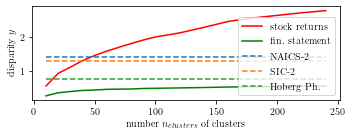

In [89]:
plt.figure(figsize=(5,2))
plt.plot(sp500_avg_disparities, label = 'stock returns', color = 'red')
plt.plot(statement_avg_disparities, label = 'fin. statement', color = 'green')

#plt.plot(sp500_avg_disparities.index, len(sp500_avg_disparities.index) * [reference_avg_disparities['sic_1']], label = 'SIC 1', linestyle='dashed')
plt.plot(sp500_avg_disparities.index, len(sp500_avg_disparities.index) * [reference_avg_disparities['naics_2']], label = 'NAICS-2', linestyle='dashed')
plt.plot(sp500_avg_disparities.index, len(sp500_avg_disparities.index) * [reference_avg_disparities['sic_2']], label = 'SIC-2', linestyle='dashed')
plt.plot(sp500_avg_disparities.index, len(sp500_avg_disparities.index) * [reference_avg_disparities['hp']], label = 'Hoberg Ph.', linestyle='dashed')
#plt.title('Year-aggregated Disparities for S\&P 500 Clusters')
plt.legend()
plt.ylabel('disparity $y$')
plt.xlabel('number $n_{clusters}$ of clusters')
saveplot(plt.gcf(), 'disparity_vs_n')
plt.show()

**ARI**

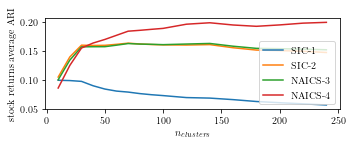

In [215]:
plt.figure(figsize=(5,2))
#plt.title('Adjusted RAND Index for different $n_{{clusters}}$ comparing to {}'.format(compare_to))
plt.ylabel(r'stock returns average ARI')
plt.xlabel('$n_{clusters}$')

plt.plot(sp500_n_clusters, average_ARIs['sic_1'][sp500_columns], label = 'SIC-1')
plt.plot(sp500_n_clusters, average_ARIs['sic_2'][sp500_columns], label = 'SIC-2')
plt.plot(sp500_n_clusters, average_ARIs['naics_3'][sp500_columns], label = 'NAICS-3')
plt.plot(sp500_n_clusters, average_ARIs['naics_4'][sp500_columns], label = 'NAICS-4')
plt.legend(loc='lower right')
saveplot(plt.gcf(), 'stock_ARI_vs_n')
plt.show()

# Use n = 30 for stock returns

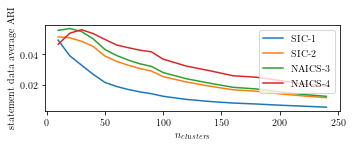

In [216]:
plt.figure(figsize=(5,2))
#plt.title('Adjusted RAND Index for different $n_{{clusters}}$ comparing to {}'.format(compare_to))
plt.ylabel('statement data average ARI')
plt.xlabel('$n_{clusters}$')

plt.plot(statement_n_clusters, average_ARIs['sic_1'][statement_columns], label = 'SIC-1')
plt.plot(statement_n_clusters, average_ARIs['sic_2'][statement_columns], label = 'SIC-2')
plt.plot(statement_n_clusters, average_ARIs['naics_3'][statement_columns], label = 'NAICS-3')
plt.plot(statement_n_clusters, average_ARIs['naics_4'][statement_columns], label = 'NAICS-4')

plt.legend()
saveplot(plt.gcf(), 'statement_ARI_vs_n')
plt.show()

# use n = 20 for statements

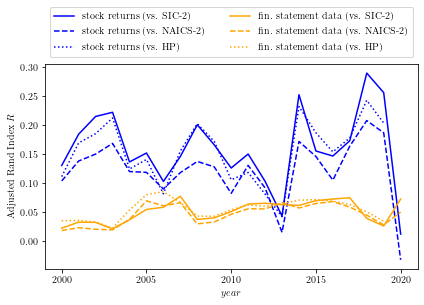

In [217]:
plt.figure(figsize=(6,4.5))
#plt.title('Adjusted RAND Index time evolution comparing to {}'.format(compare_to))
plt.ylabel('Adjusted Rand Index $R$')
plt.xlabel('$year$')

sp_series_1 = [yearly_ARIs[year]['sic_2']['sp_{}'.format(30)] for year in yearly_ARIs]
sp_series_2 = [yearly_ARIs[year]['naics_2']['sp_{}'.format(30)] for year in yearly_ARIs]
sp_series_3 = [yearly_ARIs[year]['hp']['sp_{}'.format(30)] for year in yearly_ARIs]
st_series_1 = [yearly_ARIs[year]['sic_2']['st_{}'.format(20)] for year in yearly_ARIs]
st_series_2 = [yearly_ARIs[year]['naics_2']['st_{}'.format(20)] for year in yearly_ARIs]
st_series_3 = [yearly_ARIs[year]['hp']['st_{}'.format(20)] for year in yearly_ARIs]

plt.plot(years, sp_series_1, label = 'stock returns (vs. SIC-2)', color = 'blue')
plt.plot(years, sp_series_2, label = 'stock returns (vs. NAICS-2)', color = 'blue', linestyle='dashed')
plt.plot(years[0:-1], sp_series_3[:-1], label = 'stock returns (vs. HP)', color = 'blue', linestyle='dotted')
plt.plot(years, st_series_1, label = 'fin. statement data (vs. SIC-2)', color = 'orange')
plt.plot(years, st_series_2, label = 'fin. statement data (vs. NAICS-2)', color = 'orange', linestyle='dashed')
plt.plot(years[0:-1], st_series_3[:-1], label = 'fin. statement data (vs. HP)', color = 'orange', linestyle='dotted')

plt.legend(loc='upper left', ncol=2, mode='expand', bbox_to_anchor=(0., 1.3, 1., 0))
plt.locator_params(axis="x", integer=True)
saveplot(plt.gcf(), 'ARI_vs_year')
plt.show()

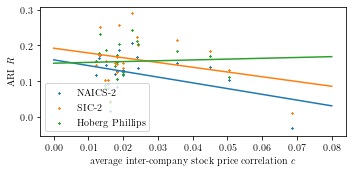

NAICS2: R²: 0.18011893222921438 p: 0.05516785815045212 slope: -1.609634837807419
SIC2  : R²: 0.08217290378576679 p: 0.2077280658627055 slope: -1.3327692590117848
HP    : R²: 0.0019521817230427026 p: 0.8532594351034786 slope: 0.22947444575304393


In [218]:
# regression: stock ARI vs correlation
yearly_sp30_vs_naics_2_ARIs = np.array([yearly_ARIs[year].at['sp_30', 'naics_2'] for year in yearly_ARIs])
yearly_sp30_vs_sic_2_ARIs = np.array([yearly_ARIs[year].at['sp_30', 'sic_2'] for year in yearly_ARIs])
yearly_sp30_vs_hp_ARIs = np.array([yearly_ARIs[year].at['sp_30', 'hp'] for year in yearly_ARIs if year != 2020])

plt.figure(figsize=(5, 2.5))
x = avg_detrended_correlations['avg_corr']
x_hp = x[:-1]
x_space = np.linspace(0.0, 0.08)
y_sp_1 = yearly_sp30_vs_naics_2_ARIs
y_sp_2 = yearly_sp30_vs_sic_2_ARIs
y_sp_3 = yearly_sp30_vs_hp_ARIs

slope_sp_1, intercept_sp_1, r_value_sp_1, p_value_sp_1, _ = sp.stats.linregress(x=x, y=y_sp_1)
slope_sp_2, intercept_sp_2, r_value_sp_2, p_value_sp_2, _ = sp.stats.linregress(x=x, y=y_sp_2)
slope_sp_3, intercept_sp_3, r_value_sp_3, p_value_sp_3, _ = sp.stats.linregress(x=x_hp, y=y_sp_3)

plt.scatter(x, y_sp_1, label = 'NAICS-2', marker = 'x', s = 2)
plt.scatter(x, y_sp_2, label = 'SIC-2', marker = 'x', s = 2)
plt.scatter(x_hp, y_sp_3, label = 'Hoberg Phillips', marker = 'x', s = 2)

plt.plot(x_space, intercept_sp_1 + slope_sp_1 * x_space)
plt.plot(x_space, intercept_sp_2 + slope_sp_2 * x_space)
plt.plot(x_space, intercept_sp_3 + slope_sp_3 * x_space)

plt.xlabel('average inter-company stock price correlation $c$')
plt.ylabel('ARI $R$')
plt.legend()
saveplot(plt.gcf(), 'ARI_vs_correlation_stock')
plt.show()
print('NAICS2: R²:', r_value_sp_1**2, 'p:', p_value_sp_1, 'slope:', slope_sp_1)
print('SIC2  : R²:', r_value_sp_2**2, 'p:', p_value_sp_2, 'slope:', slope_sp_2)
print('HP    : R²:', r_value_sp_3**2, 'p:', p_value_sp_3, 'slope:', slope_sp_3)

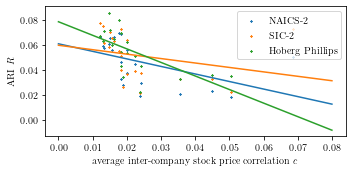

NAICS2: R²: 0.23270396119887948 p: 0.026778583061275372 slope: -0.6012577005271622
SIC2  : R²: 0.0747623577993144 p: 0.23041274791938102 slope: -0.3534938769726269
HP    : R²: 0.4178836500808422 p: 0.0020716146327940193 slope: -1.0807734848603963


In [219]:
# regression: statement ARI vs correlation
yearly_st20_vs_naics_2_ARIs = np.array([yearly_ARIs[year].at['st_20', 'naics_2'] for year in yearly_ARIs])
yearly_st20_vs_sic_2_ARIs = np.array([yearly_ARIs[year].at['st_20', 'sic_2'] for year in yearly_ARIs])
yearly_st20_vs_hp_ARIs = np.array([yearly_ARIs[year].at['st_20', 'hp'] for year in yearly_ARIs if year != 2020])

plt.figure(figsize=(5, 2.5))
x = avg_detrended_correlations['avg_corr']
x_hp = x[:-1]
x_space = np.linspace(0.0, 0.08)
y_st_1 = yearly_st20_vs_naics_2_ARIs
y_st_2 = yearly_st20_vs_sic_2_ARIs
y_st_3 = yearly_st20_vs_hp_ARIs

slope_st_1, intercept_st_1, r_value_st_1, p_value_st_1, _ = sp.stats.linregress(x=x, y=y_st_1)
slope_st_2, intercept_st_2, r_value_st_2, p_value_st_2, _ = sp.stats.linregress(x=x, y=y_st_2)
slope_st_3, intercept_st_3, r_value_st_3, p_value_st_3, _ = sp.stats.linregress(x=x_hp, y=y_st_3)

plt.scatter(x, y_st_1, label = 'NAICS-2', marker = 'x', s = 2)
plt.scatter(x, y_st_2, label = 'SIC-2', marker = 'x', s = 2)
plt.scatter(x_hp, y_st_3, label = 'Hoberg Phillips', marker = 'x', s = 2)

plt.plot(x_space, intercept_st_1 + slope_st_1 * x_space)
plt.plot(x_space, intercept_st_2 + slope_st_2 * x_space)
plt.plot(x_space, intercept_st_3 + slope_st_3 * x_space)

plt.xlabel('average inter-company stock price correlation $c$')
plt.ylabel('ARI $R$')
plt.legend()
saveplot(plt.gcf(), 'ARI_vs_correlation_statement')
plt.show()
print('NAICS2: R²:', r_value_st_1**2, 'p:', p_value_st_1, 'slope:', slope_st_1)
print('SIC2  : R²:', r_value_st_2**2, 'p:', p_value_st_2, 'slope:', slope_st_2)
print('HP    : R²:', r_value_st_3**2, 'p:', p_value_st_3, 'slope:', slope_st_3)

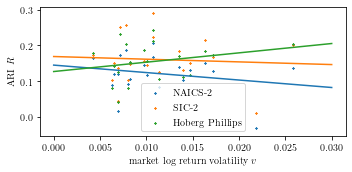

NAICS2: R²: 0.043602141725704875 p: 0.363682450155267 slope: -2.0906570463068777
SIC2  : R²: 0.003738569300297833 p: 0.79233091919598 slope: -0.7504548554181314
HP    : R²: 0.05938915029502457 p: 0.30048431899134126 slope: 2.6150954966117936


In [220]:
# regression: stock ARI vs volatility
yearly_sp30_vs_naics_2_ARIs = np.array([yearly_ARIs[year].at['sp_30', 'naics_2'] for year in yearly_ARIs])
yearly_sp30_vs_sic_2_ARIs = np.array([yearly_ARIs[year].at['sp_30', 'sic_2'] for year in yearly_ARIs])
yearly_sp30_vs_hp_ARIs = np.array([yearly_ARIs[year].at['sp_30', 'hp'] for year in yearly_ARIs if year != 2020])

plt.figure(figsize=(5, 2.5))
x = yearly_vola['vola']
x_hp = x[:-1]
x_space = np.linspace(0.0, 0.03)
y_sp_1 = yearly_sp30_vs_naics_2_ARIs
y_sp_2 = yearly_sp30_vs_sic_2_ARIs
y_sp_3 = yearly_sp30_vs_hp_ARIs

slope_sp_1, intercept_sp_1, r_value_sp_1, p_value_sp_1, _ = sp.stats.linregress(x=x, y=y_sp_1)
slope_sp_2, intercept_sp_2, r_value_sp_2, p_value_sp_2, _ = sp.stats.linregress(x=x, y=y_sp_2)
slope_sp_3, intercept_sp_3, r_value_sp_3, p_value_sp_3, _ = sp.stats.linregress(x=x_hp, y=y_sp_3)

plt.scatter(x, y_sp_1, label = 'NAICS-2', marker = 'x', s = 2)
plt.scatter(x, y_sp_2, label = 'SIC-2', marker = 'x', s = 2)
plt.scatter(x_hp, y_sp_3, label = 'Hoberg Phillips', marker = 'x', s = 2)

plt.plot(x_space, intercept_sp_1 + slope_sp_1 * x_space)
plt.plot(x_space, intercept_sp_2 + slope_sp_2 * x_space)
plt.plot(x_space, intercept_sp_3 + slope_sp_3 * x_space)

plt.xlabel('market log return volatility $v$')
plt.ylabel('ARI $R$')
plt.legend()
saveplot(plt.gcf(), 'ARI_vs_vola_stock')
plt.show()
print('NAICS2: R²:', r_value_sp_1**2, 'p:', p_value_sp_1, 'slope:', slope_sp_1)
print('SIC2  : R²:', r_value_sp_2**2, 'p:', p_value_sp_2, 'slope:', slope_sp_2)
print('HP    : R²:', r_value_sp_3**2, 'p:', p_value_sp_3, 'slope:', slope_sp_3)

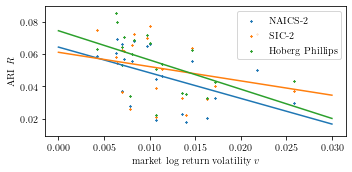

NAICS2: R²: 0.23194476438023764 p: 0.027064272911583354 slope: -1.584645985106713
SIC2  : R²: 0.06698605071158965 p: 0.2572738303271567 slope: -0.8833113117431257
HP    : R²: 0.2732790304169363 p: 0.018035170888017406 slope: -1.8058011877483073


In [221]:
# regression: statement ARI vs volatility
yearly_st20_vs_naics_2_ARIs = np.array([yearly_ARIs[year].at['st_20', 'naics_2'] for year in yearly_ARIs])
yearly_st20_vs_sic_2_ARIs = np.array([yearly_ARIs[year].at['st_20', 'sic_2'] for year in yearly_ARIs])
yearly_st20_vs_hp_ARIs = np.array([yearly_ARIs[year].at['st_20', 'hp'] for year in yearly_ARIs if year != 2020])

plt.figure(figsize=(5, 2.5))
x = yearly_vola['vola']
x_hp = x[:-1]
x_space = np.linspace(0.0, 0.03)
y_st_1 = yearly_st20_vs_naics_2_ARIs
y_st_2 = yearly_st20_vs_sic_2_ARIs
y_st_3 = yearly_st20_vs_hp_ARIs

slope_st_1, intercept_st_1, r_value_st_1, p_value_st_1, _ = sp.stats.linregress(x=x, y=y_st_1)
slope_st_2, intercept_st_2, r_value_st_2, p_value_st_2, _ = sp.stats.linregress(x=x, y=y_st_2)
slope_st_3, intercept_st_3, r_value_st_3, p_value_st_3, _ = sp.stats.linregress(x=x_hp, y=y_st_3)

plt.scatter(x, y_st_1, label = 'NAICS-2', marker = 'x', s = 2)
plt.scatter(x, y_st_2, label = 'SIC-2', marker = 'x', s = 2)
plt.scatter(x_hp, y_st_3, label = 'Hoberg Phillips', marker = 'x', s = 2)

plt.plot(x_space, intercept_st_1 + slope_st_1 * x_space)
plt.plot(x_space, intercept_st_2 + slope_st_2 * x_space)
plt.plot(x_space, intercept_st_3 + slope_st_3 * x_space)

plt.xlabel('market log return volatility $v$')
plt.ylabel('ARI $R$')
plt.legend()
saveplot(plt.gcf(), 'ARI_vs_vola_statement')
plt.show()
print('NAICS2: R²:', r_value_st_1**2, 'p:', p_value_st_1, 'slope:', slope_st_1)
print('SIC2  : R²:', r_value_st_2**2, 'p:', p_value_st_2, 'slope:', slope_st_2)
print('HP    : R²:', r_value_st_3**2, 'p:', p_value_st_3, 'slope:', slope_st_3)

**Intra-Cluster Variances**

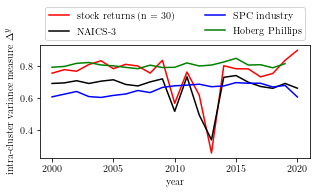

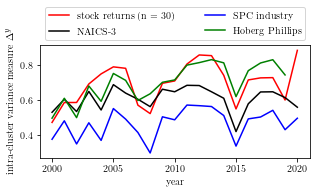

In [222]:
for benchmark in ['leverage', 'ebit_margin']:
    plt.figure(figsize=(4.5,2.8))
    plt.ylabel('intra-cluster variance measure $\Delta^y$')
    plt.xlabel('year')

    plt.plot(intra_cluster_std_ratios[benchmark]['sp_30'], label='stock returns (n = 30)', color = 'red')
    plt.plot(intra_cluster_std_ratios[benchmark]['naics_3'], label='NAICS-3', color = 'black')
    plt.plot(intra_cluster_std_ratios[benchmark]['spcindcd'], label='SPC industry', color = 'blue')
    plt.plot(intra_cluster_std_ratios[benchmark]['hp'], label='Hoberg Phillips', color = 'green')

    plt.plot([2000], [0.7572431081222134])
    plt.legend(loc = 'lower right', ncol =2, bbox_to_anchor=(0., 1., 1., .1), mode='expand')
    plt.locator_params(axis="x", integer=True)
    saveplot(plt.gcf(), 'std_ratio_{}'.format(benchmark))
    plt.show()

## Medoids

**Medoid overview**

In [175]:
sp_10_medoids = pd.DataFrame(index = years, columns = [x for x in range(1, 11)])
st_10_medoids = pd.DataFrame(index = years, columns = [x for x in range(1, 11)])

for year in yearly_medoids:
    sp_10_medoids.loc[year] = sorted(yearly_medoids[year]['ismedoid_sp_10'])
    st_10_medoids.loc[year] = sorted(yearly_medoids[year]['ismedoid_st_10'])

In [230]:
def yearly_medoids_overview(medoids):
    s = ''
    df = pd.DataFrame(columns = ['year', 'tic', 'conm', 'busdesc'], index = ['{}/{}'.format(year, i) for (year, i) in itertools.product(years, medoids.columns)])
    for year in medoids.index:
        s += '{}:\n'.format(year)
        for col in medoids.columns:
            tic = medoids.at[year, col]
            name = company_data.set_index('tic').loc[tic]['conm']
            desc = company_data.set_index('tic').loc[tic]['busdesc']
            s += ('       {tic:7.7}    {name:30.30}   {desc:500.500}'.format(tic=tic, name=name, desc=desc)) + '\n'
            df.loc['{}/{}'.format(year, col)] = [year, tic, name, desc]
    return s, df

In [231]:
s, df = yearly_medoids_overview(sp_10_medoids)power setpower setpower set
df.to_csv(r'clusters/sp500_10_medoids.csv')
with open(r'clusters/sp500_10_medoids.txt', 'w') as f:
    f.write(s)

s, df = yearly_medoids_overview(st_10_medoids)
df.to_csv(r'clusters/statement_10_medoids.csv')
with open(r'clusters/statement_10_medoids.txt', 'w') as f:
    f.write(s)

**Complete lists**

In [167]:
# TODO: for selected years (2014, 2020) print medoids + all (sorted by closeness to medoid) cluster members by Saturday

In [86]:
medoid_analysis_n_clusters = [30]

medoid_file_wildcard = r'medoids/{n}/{method}/cluster_{year}_{num}.csv'
latex_medoid_table_file_wildcard = r'medoids/{n}/{method}/latex_{year}.tex'

latex_row_wildcard = r'{medoid} ({medoid_tic}) & {cluster_members} \\\midrule'
latex_cluster_member_wildcard = '{conm} ({dist:.2f})'

for n in medoid_analysis_n_clusters:
    for method in ['sp', 'st']:
        for year in years:
            # prepare all data needed (clusters, medoids, distance matrices)
            cluster_lists = make_cluster_lists(yearly_clusters[year]['{}_{}'.format(method, n)])
            medoids = yearly_medoids[year]['ismedoid_{}_{}'.format(method, n)]
            distance_matrix = pd.read_csv(
                (r'sp500/sp500_yearly_distmat_{}.csv' if method == 'sp' else r'financial_statement/distance_matrices_combined3/cluster_{}.csv').format(year),
                index_col = 0)
            
            latex_string = ''
            
            # prepare a file for each medoid
            for medoid in medoids:
                
                # Find the cluster containing the medoid (yeah, this is a bit inefficient, but ....)
                for cluster_list_idx in cluster_lists:
                    if medoid in cluster_lists[cluster_list_idx]:
                        cluster_list = cluster_lists[cluster_list_idx]
                        break
                        
                
                # fill a dataframe and save it
                df = pd.DataFrame(columns = ['dist', 'conm', 'busdesc'], index = cluster_list)
                df['conm'] = company_data.set_index('tic')['conm']
                df['busdesc'] = company_data.set_index('tic')['busdesc']
                df['dist'] = distance_matrix[medoid].round(4)
                df.sort_values('dist', inplace=True)
                df.to_csv(medoid_file_wildcard.format(n = n, method = method, year = year, num = medoid))
                
                if medoid in company_data.set_index('tic').index:
                    latex_cluster_members_row = ', '.join([latex_cluster_member_wildcard.format(
                        conm = (str(df['conm'][i]).replace('&', r'\&')), 
                                dist=float(df['dist'][i])
                    ) for i in df.index[1:]])
                    latex_row = latex_row_wildcard.format(
                        medoid = company_data.set_index('tic')['conm'][medoid], 
                        medoid_tic = medoid,
                        cluster_members = latex_cluster_members_row
                    )
                    latex_string += latex_row + '\n'
            
            with open(latex_medoid_table_file_wildcard.format(n=n, year=year, method=method), 'w') as f:
                f.write(latex_string)
                
            
        

## Finding Classification Numbers

In [38]:
#n_clusters_clusterings = ['sic_1', 'sic_2', 'hp', 'naics_2', 'naics_3', 'naics_4', 'ggroup', 'gsector', 'spc']

cluster_numbers = pd.DataFrame(columns = yearly_clusters[2000].columns, index = years)
for year in years:
    for col in cluster_numbers.columns:
        unique = yearly_clusters[year][col].unique()
        cluster_numbers.at[year, col] = len(unique) -1 if np.isnan(unique.sum()) else len(unique)

In [49]:
cluster_numbers.max()['hp']

26.0